In [2]:
!pip install numpy matplotlib pandas scikit-learn keras tensorflow opencv-contrib-python

Kaggle Data Setup

In [3]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'asl-alphabet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F23079%2F29550%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240304%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240304T064750Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Daffc4c192a1acf4105b7db91602936afdf2d82ccf1554f481afbc66cbff9cd8c9a21798caa4168615f8f3a4dbff0a6f9a34b68da7fc3782d3a24170362f75a19d03b259be0d25905a40be7e8a8338d1a4815b891844d0b622744373f59366a320d17c1791fe2d9703ea577172837a75da31168d20a9b612337ffe544d55ef4010544af432727bb336168c1a1bed456ae0e9862bfaaf50abe85085230c80eb37e24cbad926f079e2a90f7a79b6ee7b48311634dcd8d090ee89423a2a3a47e39e16b70b5749668719f252e236246b5c934f8e2ad106732be36200bf3da5facb881d47718cab7eb2226b789148a07da61cdccb4d9154723c67b9bd838a63694cc7e,asl-alphabet-test:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F39899%2F61859%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240304%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240304T064750Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D925a7da086ba2ecc49f4b052e090c236a709ad2d75f12672ff4f445f6f7c23bd0cfda57ef50be781a3f761184ab16c54d55a08fb66377c4659a2d6f0809f09f62ffcede7cff30bad8eb823936170bb396d860b2b2d49d9856dcde5eb918f711785ebba91c6fa7729641444c872ff13b6906244c2e3b11b21093f8ea96002389ba1f45bbac380dcd120fbee49c0e93acce3c06c56f75918a23ea9aba53e9caf56605714266a34ff98a4c46ec32a701adfd618e8403f89029076c9d81ba2233937dc40901ea452e8ac654c7ca1056adce341ee2d274625b35d2d7426a52679a569833f2324a43c3c484d012d6a3ba26ec92fbc09304eb5ecd95629bd40a9fea4ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1100887034 bytes downloaded
Downloaded and uncompressed: asl-alphabet
[==================================================] 25489344 bytes downloaded
Downloaded and uncompressed: asl-alphabet-test
Data source import complete.


Data Loading

In [4]:
import numpy as np
np.random.seed(5)
import tensorflow as tf
tf.random.set_seed(2)
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

train_dir = "../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
eval_dir = "../input/asl-alphabet-test/asl-alphabet-test"

Since the data is held in multiple folders in the directories, it is necessary to extract it and store it in arrays. Since I will be doing this operation twice - once on the training data, and again on the evaluation data, it makes sense to write a function that helps with this exaction. This is the function given below, which takes each individual image, resizes it to a convenient size and adds it to an array. It also adds the corresponding label code to a labels array.

In [5]:
#function to load images from given directories
def load_images(directory):
    images = []
    labels = []
    for idx, label in enumerate(uniq_labels):
        for file in os.listdir(directory + "/" + label):
            filepath = directory + "/" + label + "/" + file
            image = cv2.resize(cv2.imread(filepath), (64, 64))
            images.append(image)
            labels.append(idx)
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

Now that we have our helper function, we are ready to use it to extract data. This exaction takes a long time due to the large dataset. Even though I am using GPU services here, it does not help the time as these functions are not able to take advantage of the GPU.

An alternate method for dealing with such large datasets is to use generators - for the images, and the model. Generators are much faster than this manual, almost brute-force method, but they do not allow a similar easy access to the data. Which method to use is a judgement call made on the basis of time and space constraints. Since I have no such meaningful constraints here, I have used the longer method.

In [6]:
import keras

uniq_labels = sorted(os.listdir(train_dir))
images, labels = load_images(directory = train_dir)

if uniq_labels == sorted(os.listdir(eval_dir)):
    X_eval, y_eval = load_images(directory = eval_dir)

In the train-test split I have used the stratify argument on the labels. This argument ensures that the data is split evenly along all labels i.e. the proportion of each label in the testing data is the same as the proportion of the testing data itself - 10%.

Notice that I have two sets of testing images here. This is because the first test set is taken from the same data as the training set - that is, they have a similar look, while the evaluation data, taken from a separate library, has a completely different look. This is done so that I can test the model on both types of data and see how robust it is in the presence of changing backgrounds and colours. The differences between the two testing data will become clear when we look at their images.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, stratify = labels)

n = len(uniq_labels)
train_n = len(X_train)
test_n = len(X_test)

print("Total number of symbols: ", n)
print("Number of training images: " , train_n)
print("Number of testing images: ", test_n)

eval_n = len(X_eval)
print("Number of evaluation images: ", eval_n)

Total number of symbols:  29
Number of training images:  78300
Number of testing images:  8700
Number of evaluation images:  870


We are now ready to print the images for the symbols. I will print one image for each symbol, from each dataset - train, test and evaluation. Since the same operation of printing images is done thrice, I will now write a helper function for this purpose. This function will create a grid of 8x4 images and fill 29 images in the first 29 of the 32 spaces.

In [8]:
#Helper function to print images
def print_images(image_list):
    n = int(len(image_list) / len(uniq_labels))
    cols = 8
    rows = 4
    fig = plt.figure(figsize = (24, 12))

    for i in range(len(uniq_labels)):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_list[int(n*i)])
        plt.title(uniq_labels[i])
        ax.title.set_fontsize(20)
        ax.axis('off')
    plt.show()

Training Images: 


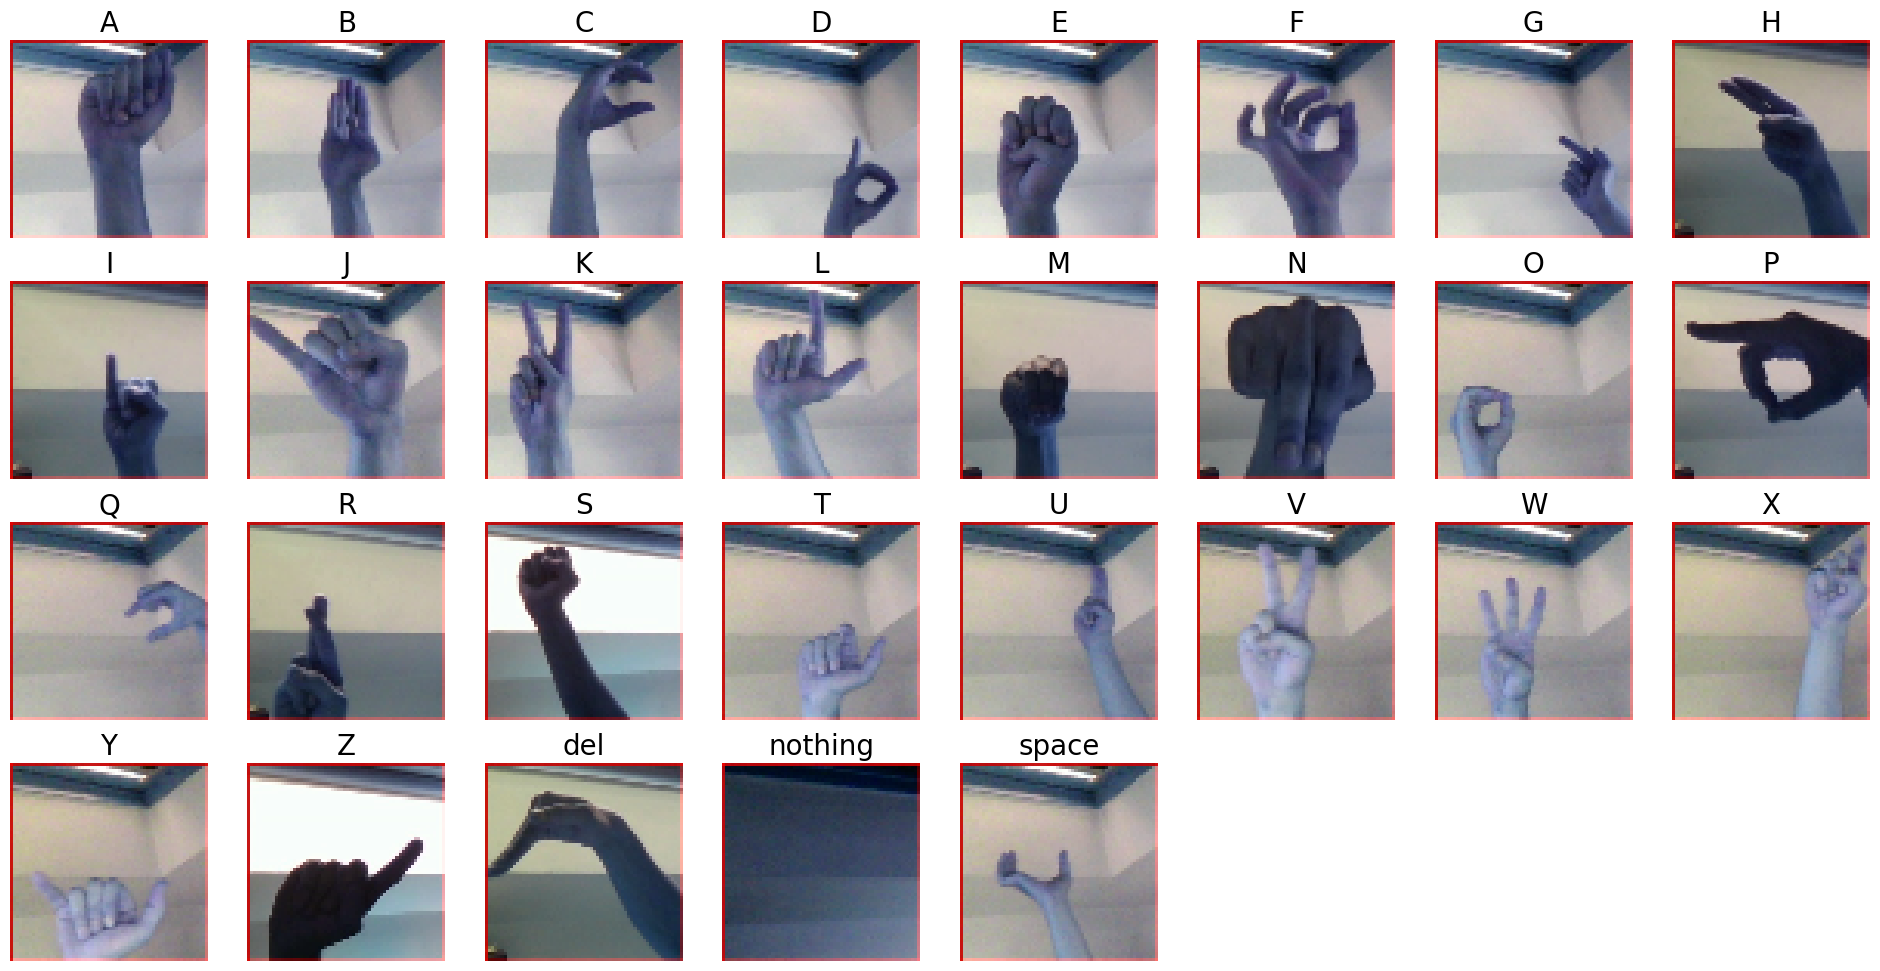

In [9]:
y_train_in = y_train.argsort()
y_train = y_train[y_train_in]
X_train = X_train[y_train_in]

print("Training Images: ")
print_images(image_list = X_train)

Testing images: 


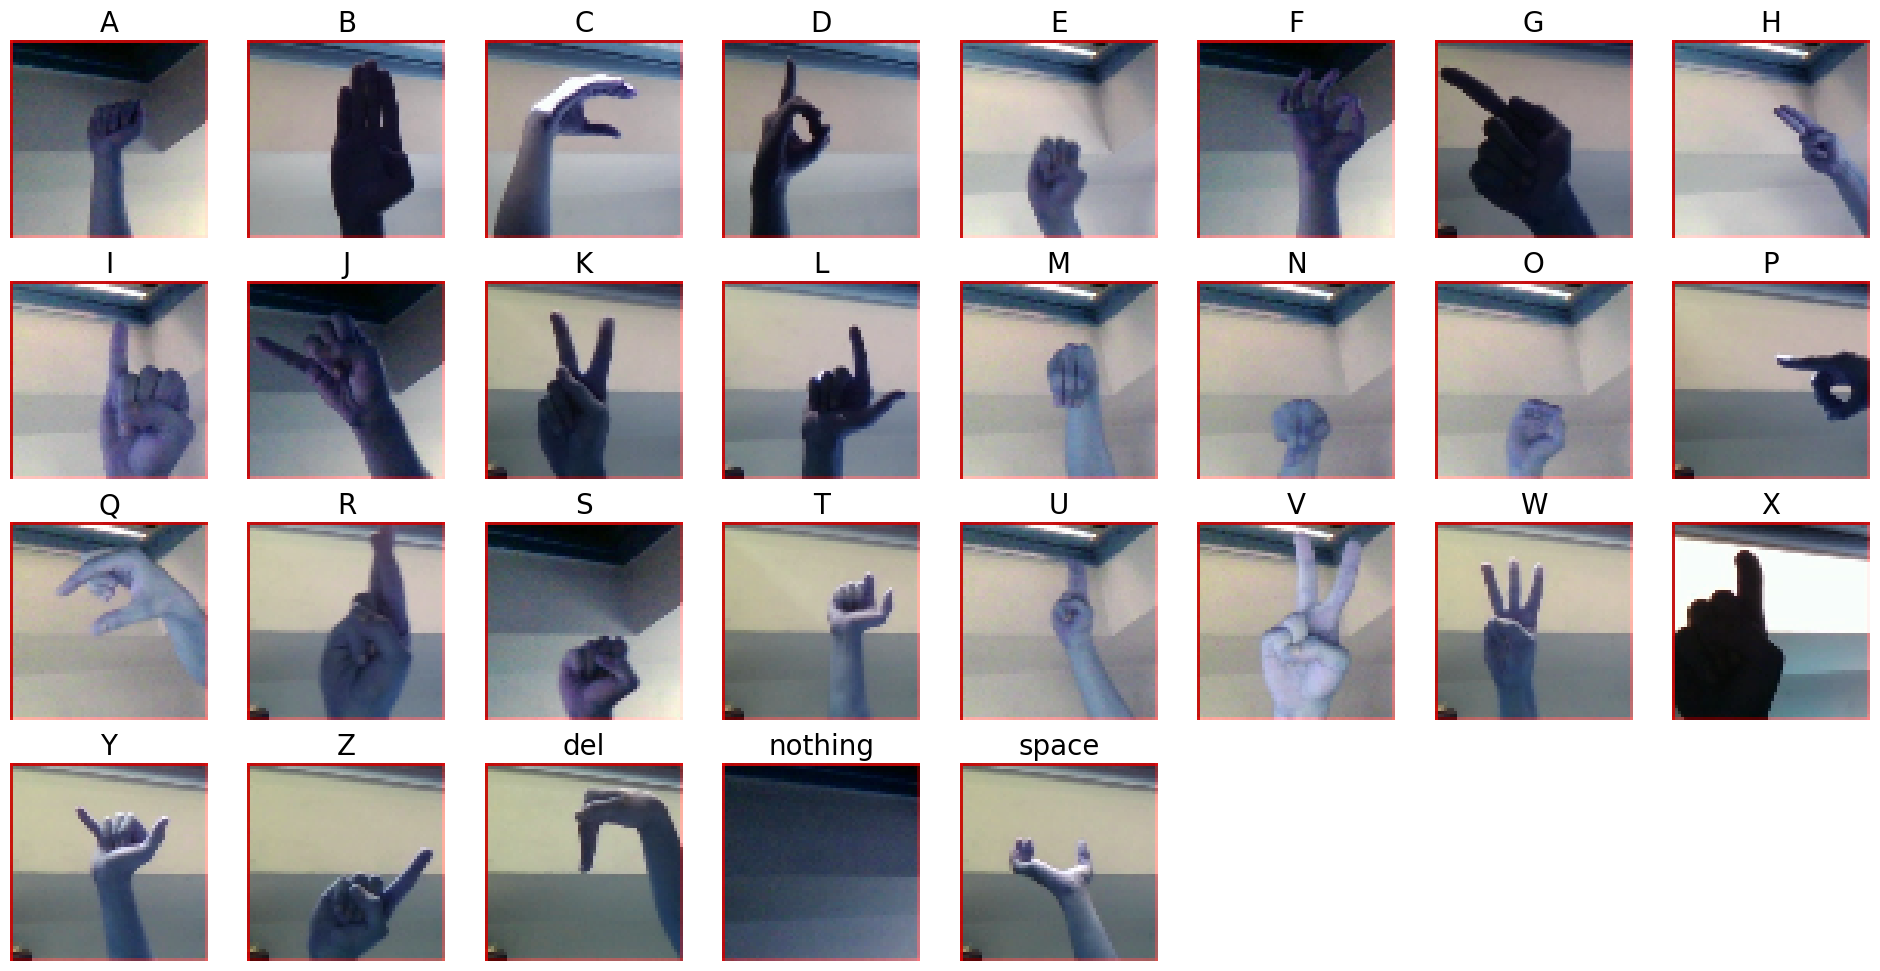

In [10]:
y_test_in = y_test.argsort()
y_test = y_test[y_test_in]
X_test = X_test[y_test_in]

print("Testing images: ")
print_images(image_list = X_test)

Evaluation images: 


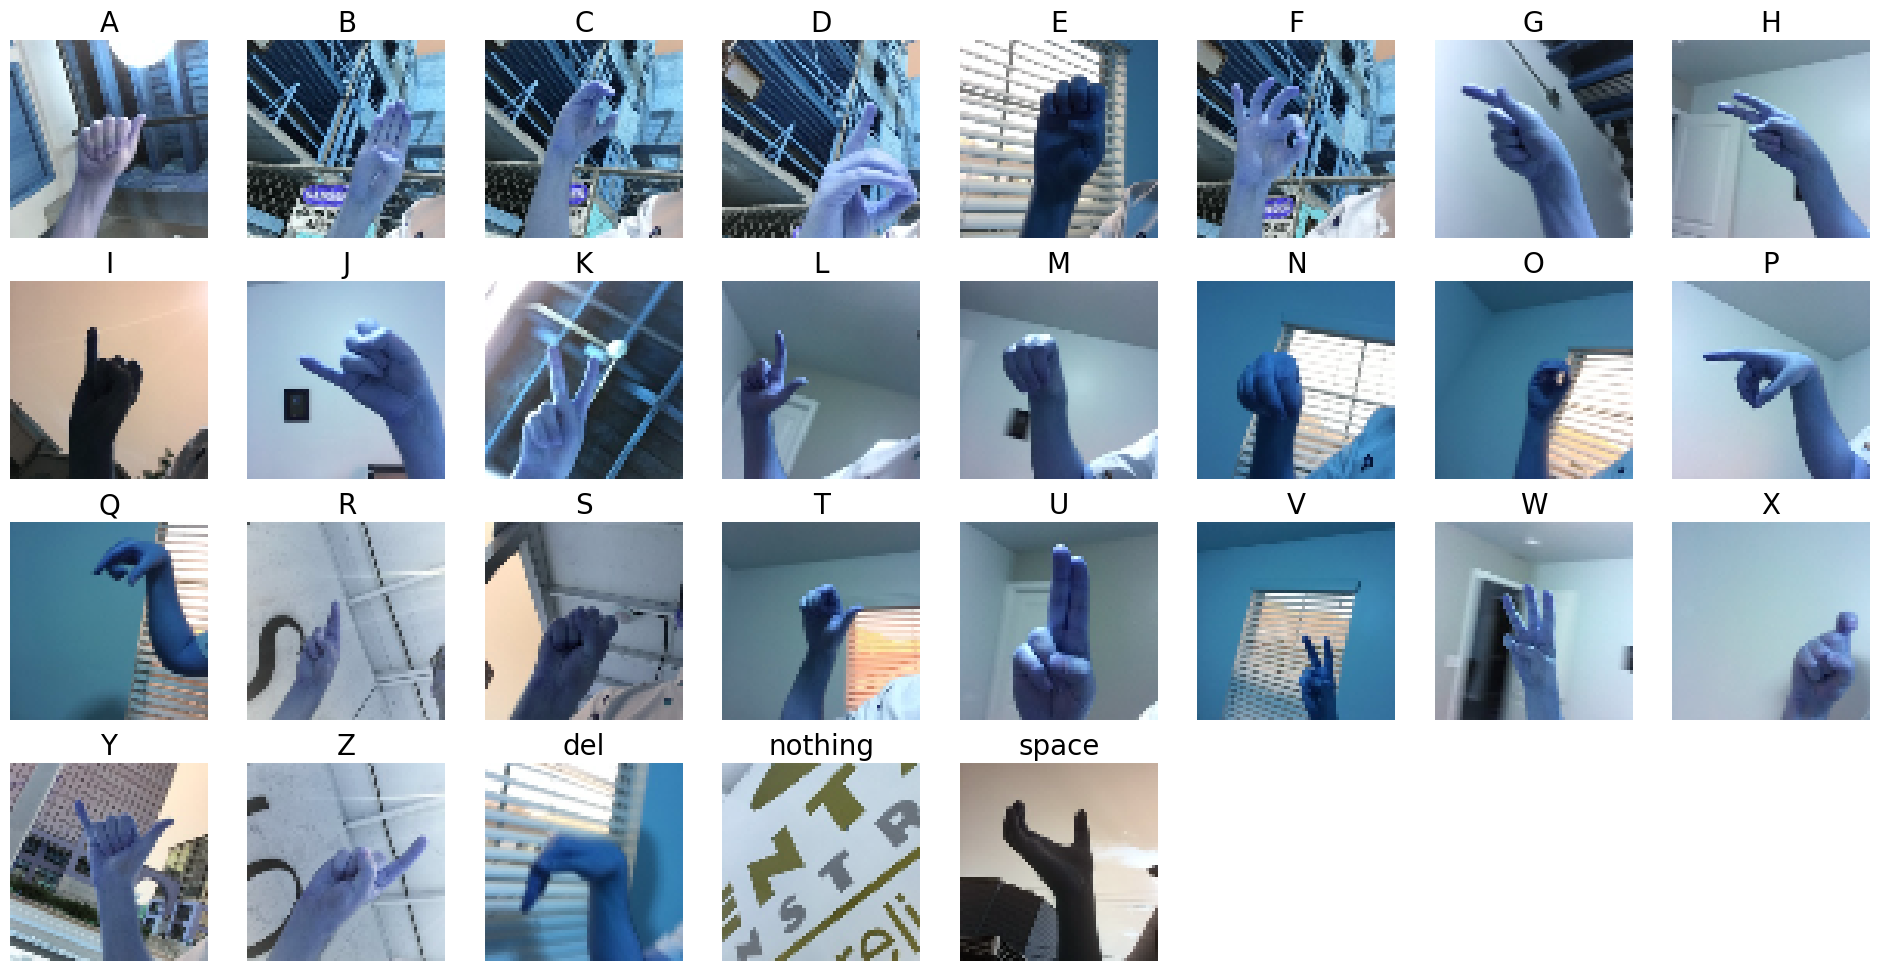

In [11]:
print("Evaluation images: ")
print_images(image_list = X_eval)

Data Preprocessing - One Hot Encoding

In [12]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [13]:
print(y_train[0])
print(len(y_train[0]))

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
29


In [14]:
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

In [15]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu',
                 input_shape = (64, 64, 3)))
model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4, 4)))
model.add(Dropout(0.5))
model.add(Conv2D(filters = 256 , kernel_size = 5, padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       409728    
                                                        

In [16]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train, epochs = 5, batch_size = 64, verbose = True)

In [ ]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

In [ ]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

In [ ]:
y_eval_pred = model.predict(X_eval, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)